# Поиск вставок

Будем искать вставки глядя на смещение GC (GC skew). Отрезки с аномальным для данной последовательности GC skew, скорее всего, и будут местами вставок.

### Case 1

Для начала посмотрим на график GC skew. Это уже позволит прикинуть место вставки с хорошей точностью. Отметим, что для такого приблизительного решения надо немного поэкспериментировать с длиной "окон", для которых вычисляется GC skew. 

Original record length: 32124
Original GC: 0.27751836633046945


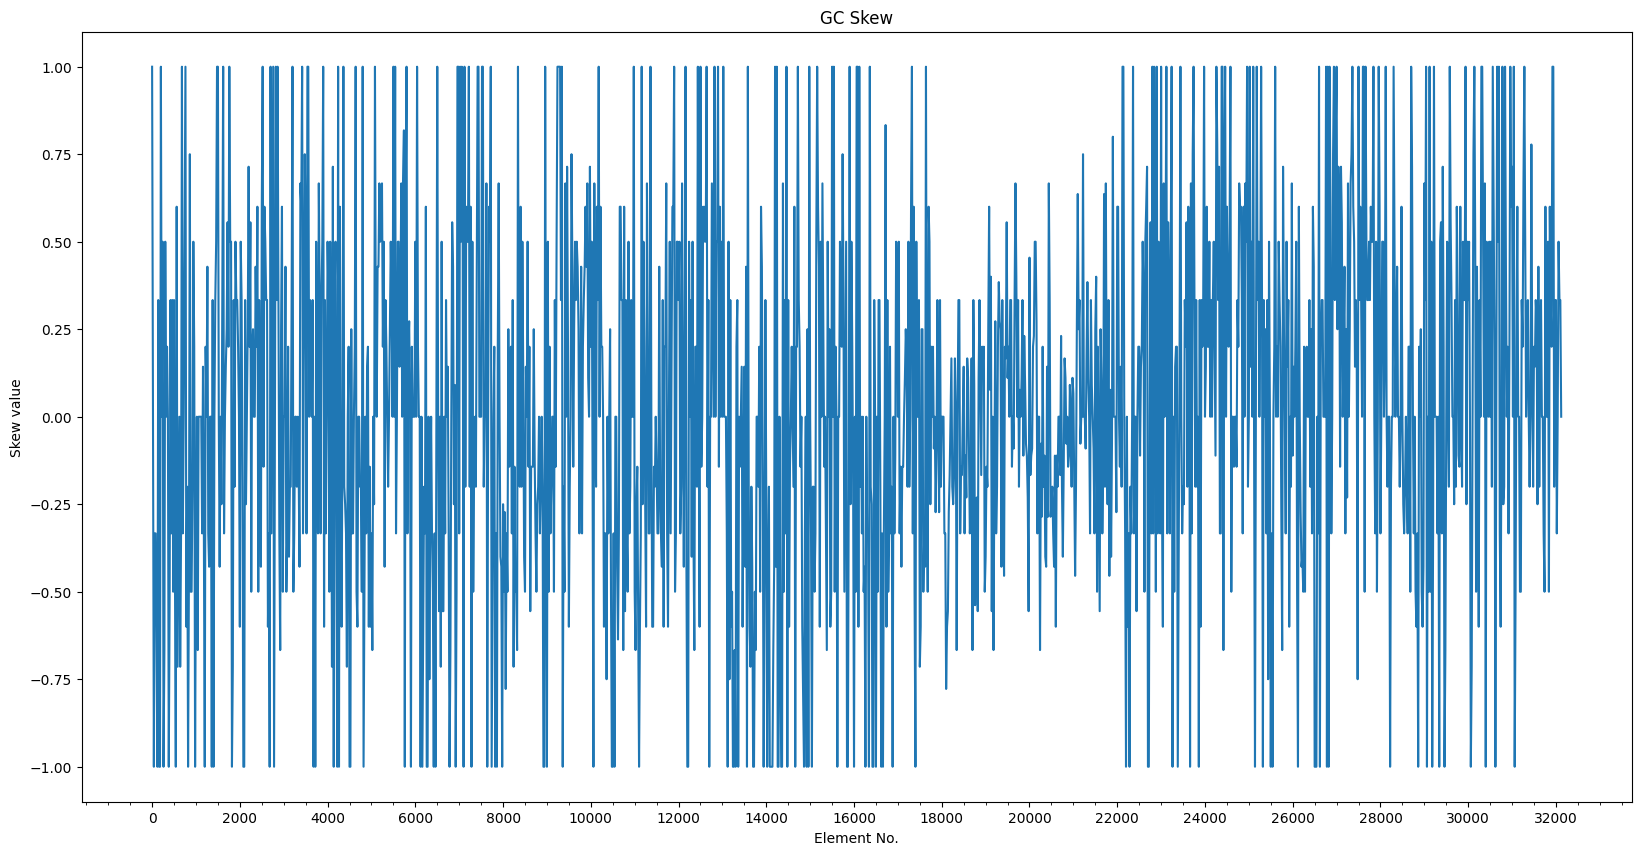

In [29]:
import Bio.SeqUtils as SU
from Bio.Seq import Seq
from Bio.SeqUtils import GC
from Bio import SeqIO

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
# import seaborn as sns

seq_orig = ""

with open("01.fasta") as handle:
    for record in SeqIO.parse(handle, "fasta"):
        seq_orig = record

gc_orig = SU.gc_fraction(seq_orig)
print(f'Original record length: {seq_orig.__len__()}')

print(f'Original GC: {gc_orig}')

current_sub = ""
current_max_insertion = ""
border_left = 0
border_right = 0

window_size = 20

skew = SU.GC_skew(seq_orig, window_size)

fig, ax = plt.subplots(figsize=(20, 10))
ax.set_title("GC Skew")
ax.plot(range(0, len(seq_orig), window_size), skew)
ax.set_xlabel("Element No.")
ax.set_ylabel("Skew value")
ax.xaxis.set_minor_locator(MultipleLocator(500))
ax.xaxis.set_major_locator(MultipleLocator(2000))
plt.show()


# for i in range(0, len(record_orig), 1):
#     print(i)
#     for j in range(i + min_size, len(record_orig)+1, step_size):
#         current_sub = record_orig[i:j]
#         # cur_dif = abs(gc_orig - SU.gc_fraction(current_sub))
#         # prev_dif = abs(gc_orig - SU.gc_fraction(current_max_insertion))

#         # wo_cur = record_orig[:i] + record_orig[j:]
#         # cur_dif = abs(gc_orig - SU.gc_fraction(current_sub))
#         SU.GC_skew()

#         # prev_dif = abs(gc_orig - SU.gc_fraction(current_max_insertion))
#         if (cur_dif > prev_dif):
#             current_max_insertion = current_sub
#             border_left = i
#             border_right = j
#             prev_dif = cur_dif


Можно заметить, что примерно между 17 500 и 22 500 элементами модуль GC skew в среднем намного ниже, чем до и после этого отрезка. Попробуем рассмотреть этот отрезок поближе.

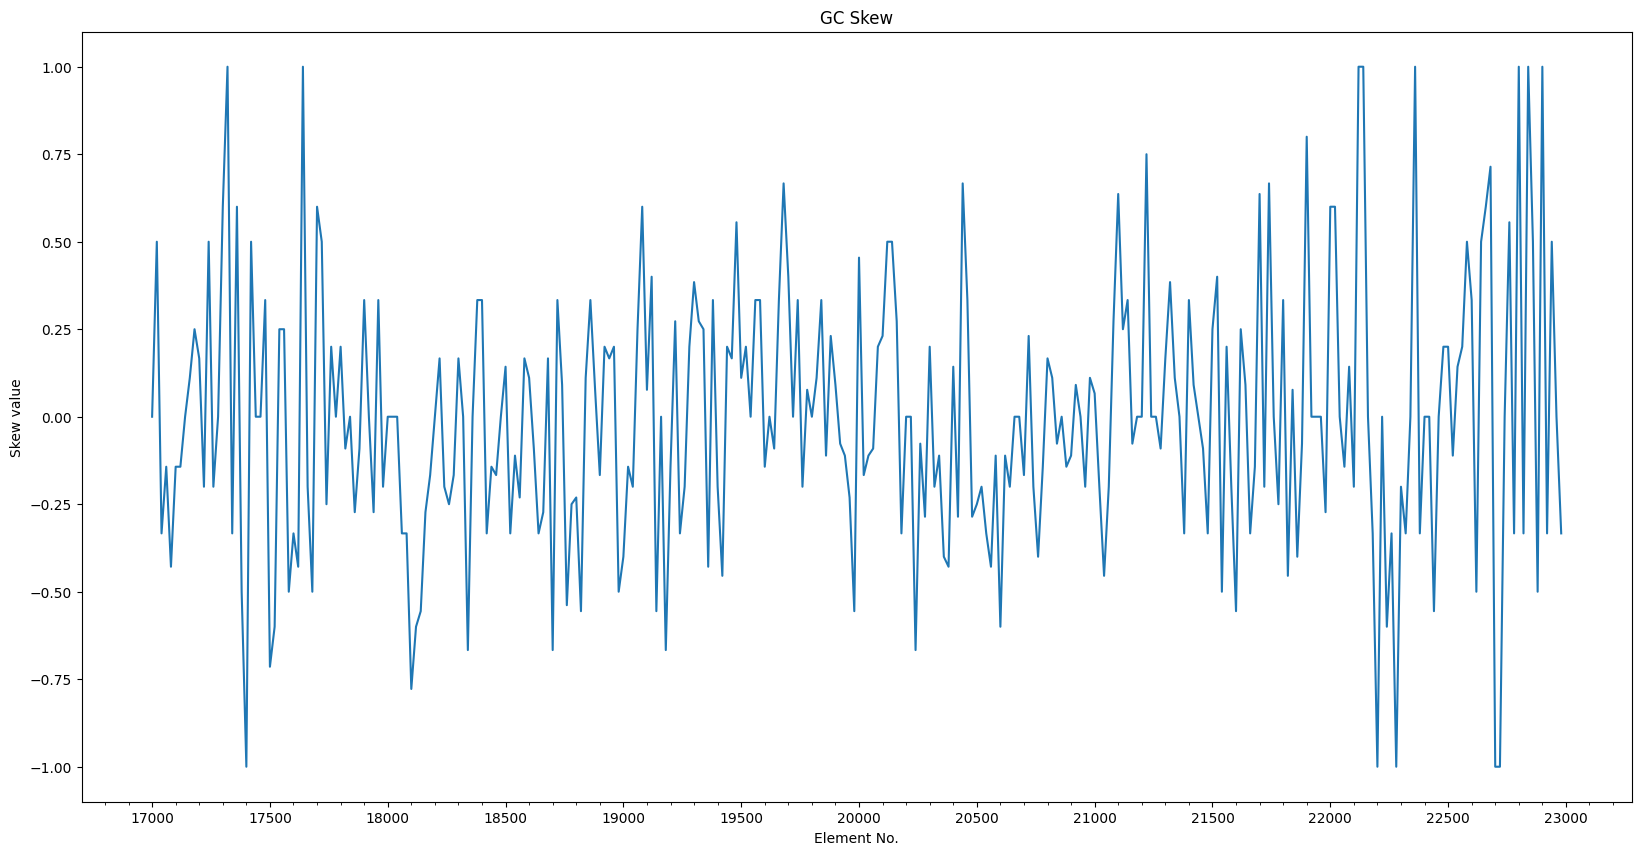

In [30]:
window_size = 20

seq_17_23 = seq_orig[17000:23000]

skew_17_23 = SU.GC_skew(seq_17_23, window_size)

fig_17_23, ax17_23 = plt.subplots(figsize=(20, 10))
ax17_23.set_title("GC Skew")
ax17_23.plot(range(17000, 23000, window_size), skew_17_23)
ax17_23.set_xlabel("Element No.")
ax17_23.set_ylabel("Skew value")
ax17_23.xaxis.set_minor_locator(MultipleLocator(100))
ax17_23.xaxis.set_major_locator(MultipleLocator(500))

plt.show()

In [31]:
print(f'Insertion length: {current_max_insertion.__len__()}')
print(f'Borders: left - {border_left}; right - {border_right}')
print(f'Insertion GC: {SU.gc_fraction(current_max_insertion)}')

Insertion length: 0
Borders: left - 0; right - 0
Insertion GC: 0
